In [4]:
import sys
import os
import json
from pprint import pprint
import glob
import numpy as np
import pandas as pd
from statistics import mean

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import matplotlib

matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.dpi']= 200
matplotlib.rcParams['figure.figsize']= (10, 8)

import matplotlib.gridspec as gridspec

In [6]:
# GENERAL SETUP

VAL_MAX = 2**16 - 1
IMAGE_SHAPE = (2048, 3072)
N_PIXELS = 2048 * 3072
data_base = "/sdf/group/magis/data_storage/DIS/"

# Dark images
# run_num = "run_01"

# Flat laser-field images
run_num = "run_01"

data_dir = f"lab/20220801/{run_num}"

run_num_global_reset = "run_02"

data_dir_global_reset=f"lab/20220801/{run_num_global_reset}"

plot_dir = f"./plots/{run_num}"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

def load_raw_image(t_exp, adc_bit, ind, global_reset=False, dtype=np.uint16, image_shape=IMAGE_SHAPE):
    if global_reset:
        with open(f"{data_base}/{data_dir_global_reset}/img_exp{t_exp}us_bitDepth{adc_bit}_{str(ind).zfill(3)}.raw", 'rb') as f:
            return np.fromfile(f, dtype=dtype).reshape(image_shape)
    else: 
        with open(f"{data_base}/{data_dir}/img_exp{t_exp}us_bitDepth{adc_bit}_{str(ind).zfill(3)}.raw", 'rb') as f:
            return np.fromfile(f, dtype=dtype).reshape(image_shape)
    
def load_average_image(t_exp, adc_bit, global_reset=False, n_images=20, dtype=np.uint16, image_shape=IMAGE_SHAPE):
    image_indices = np.arange(1, n_images+1)
    images = []
    for ind in image_indices:
        if global_reset:
            with open(f"{data_base}/{data_dir_global_reset}/img_exp{t_exp}us_bitDepth{adc_bit}_{str(ind).zfill(3)}.raw", 'rb') as f:
                images.append(np.fromfile(f, dtype=dtype).reshape(image_shape))
        else:
            with open(f"{data_base}/{data_dir}/img_exp{t_exp}us_bitDepth{adc_bit}_{str(ind).zfill(3)}.raw", 'rb') as f:
                images.append(np.fromfile(f, dtype=dtype).reshape(image_shape))
    images = np.array(images)
    return np.mean(images, axis=0), np.std(images, axis=0, ddof=1)

In [7]:
adc_bit_array = np.array([10, 12, 14])
t_exp_array = [25, 50, 100, 200, 400, 600, 800]
t_exp_array += list(range(1000, 5000, 500))
t_exp_array += list(range(5000, 205000, 5000))
t_exp_array = np.array(t_exp_array)

In [8]:
t_exp_array_global_reset = [700, 800]
t_exp_array_global_reset += list(range(1000, 5000, 500))
t_exp_array_global_reset += list(range(5000, 20000, 5000))
t_exp_array_global_reset = np.array(t_exp_array_global_reset)

In [11]:
mean_images = []
for t_exp in t_exp_array:
    mean_image, std_image = load_average_image(t_exp, 14)
    mean_images.append(mean_image)
print(mean_images)

[array([[11.4, 11. , 13.6, ...,  9.8,  9. ,  6.6],
       [12.6, 10.6, 13.8, ...,  9. ,  9.2,  7.6],
       [10.4, 15.2, 22. , ...,  7.8,  8. ,  5.6],
       ...,
       [ 9. ,  5.8,  7.4, ..., 10. , 11.4, 13.4],
       [ 6.6,  7.6,  6. , ..., 11. , 11.6, 17.8],
       [ 8.4,  8.8,  6.8, ..., 16.4, 13.8, 22.4]]), array([[10.6, 13.6, 12.8, ...,  8.8,  6. ,  6. ],
       [13.4, 10. , 11.2, ...,  7.8,  5.4,  5.4],
       [10.6, 15.8, 14.8, ...,  9.2,  5.6,  6.2],
       ...,
       [ 5.6,  5.6,  6.4, ..., 10.8, 12. , 16.4],
       [ 4.4,  6. ,  6. , ...,  7.4, 11.6, 12.6],
       [ 6.4,  4.4,  7.4, ...,  8.4, 15. , 12.8]]), array([[ 9.4, 11. , 14. , ...,  5.4,  6.2,  5.6],
       [ 9.6,  9.6, 12. , ...,  6.8,  5. ,  5. ],
       [11. , 11.6, 18.4, ...,  4.6,  6.4,  5. ],
       ...,
       [ 4.4,  5.2,  5.2, ...,  8.6, 12.6, 13.6],
       [ 4.8,  6.2,  4.2, ...,  7. ,  7. , 16.6],
       [ 5.4,  5.2,  5.4, ..., 10.8,  8.8, 12.6]]), array([[16.4, 17.4, 23.2, ...,  8.6,  8.2,  8.2],
       

In [12]:
mean_image_pixel_vals = []
for image in mean_images:
    row_means = []
    for row in image:
        row_means.append(sum(row) / len(row))
    mean_image_pixel_vals.append(sum(row_means) / len(row_means))

                                                

In [18]:
pixel_val_to_exp_model = np.polyfit(mean_image_pixel_vals, t_exp_array, 1)

In [19]:
mean_images_global_reset=[]
for t_exp in t_exp_array_global_reset:
    mean_image, std_image = load_average_image(t_exp, 14, True)
    mean_images_global_reset.append(mean_image)
    

In [20]:
gr_data = {} # in form listed exposure time: predicted exposure time per row
for i in range(len(mean_images_global_reset)):
    listed_exp_time = t_exp_array_global_reset[i]
    mean_image = mean_images_global_reset[i]
    row_exp_times = []
    for row in mean_image:
        avg_pixel_val = sum(row) / len(row)
        exp_time_predict = (pixel_val_to_exp_model[0] * avg_pixel_val) + pixel_val_to_exp_model[1]
        row_exp_times.append(exp_time_predict)
    gr_data[listed_exp_time] = row_exp_times


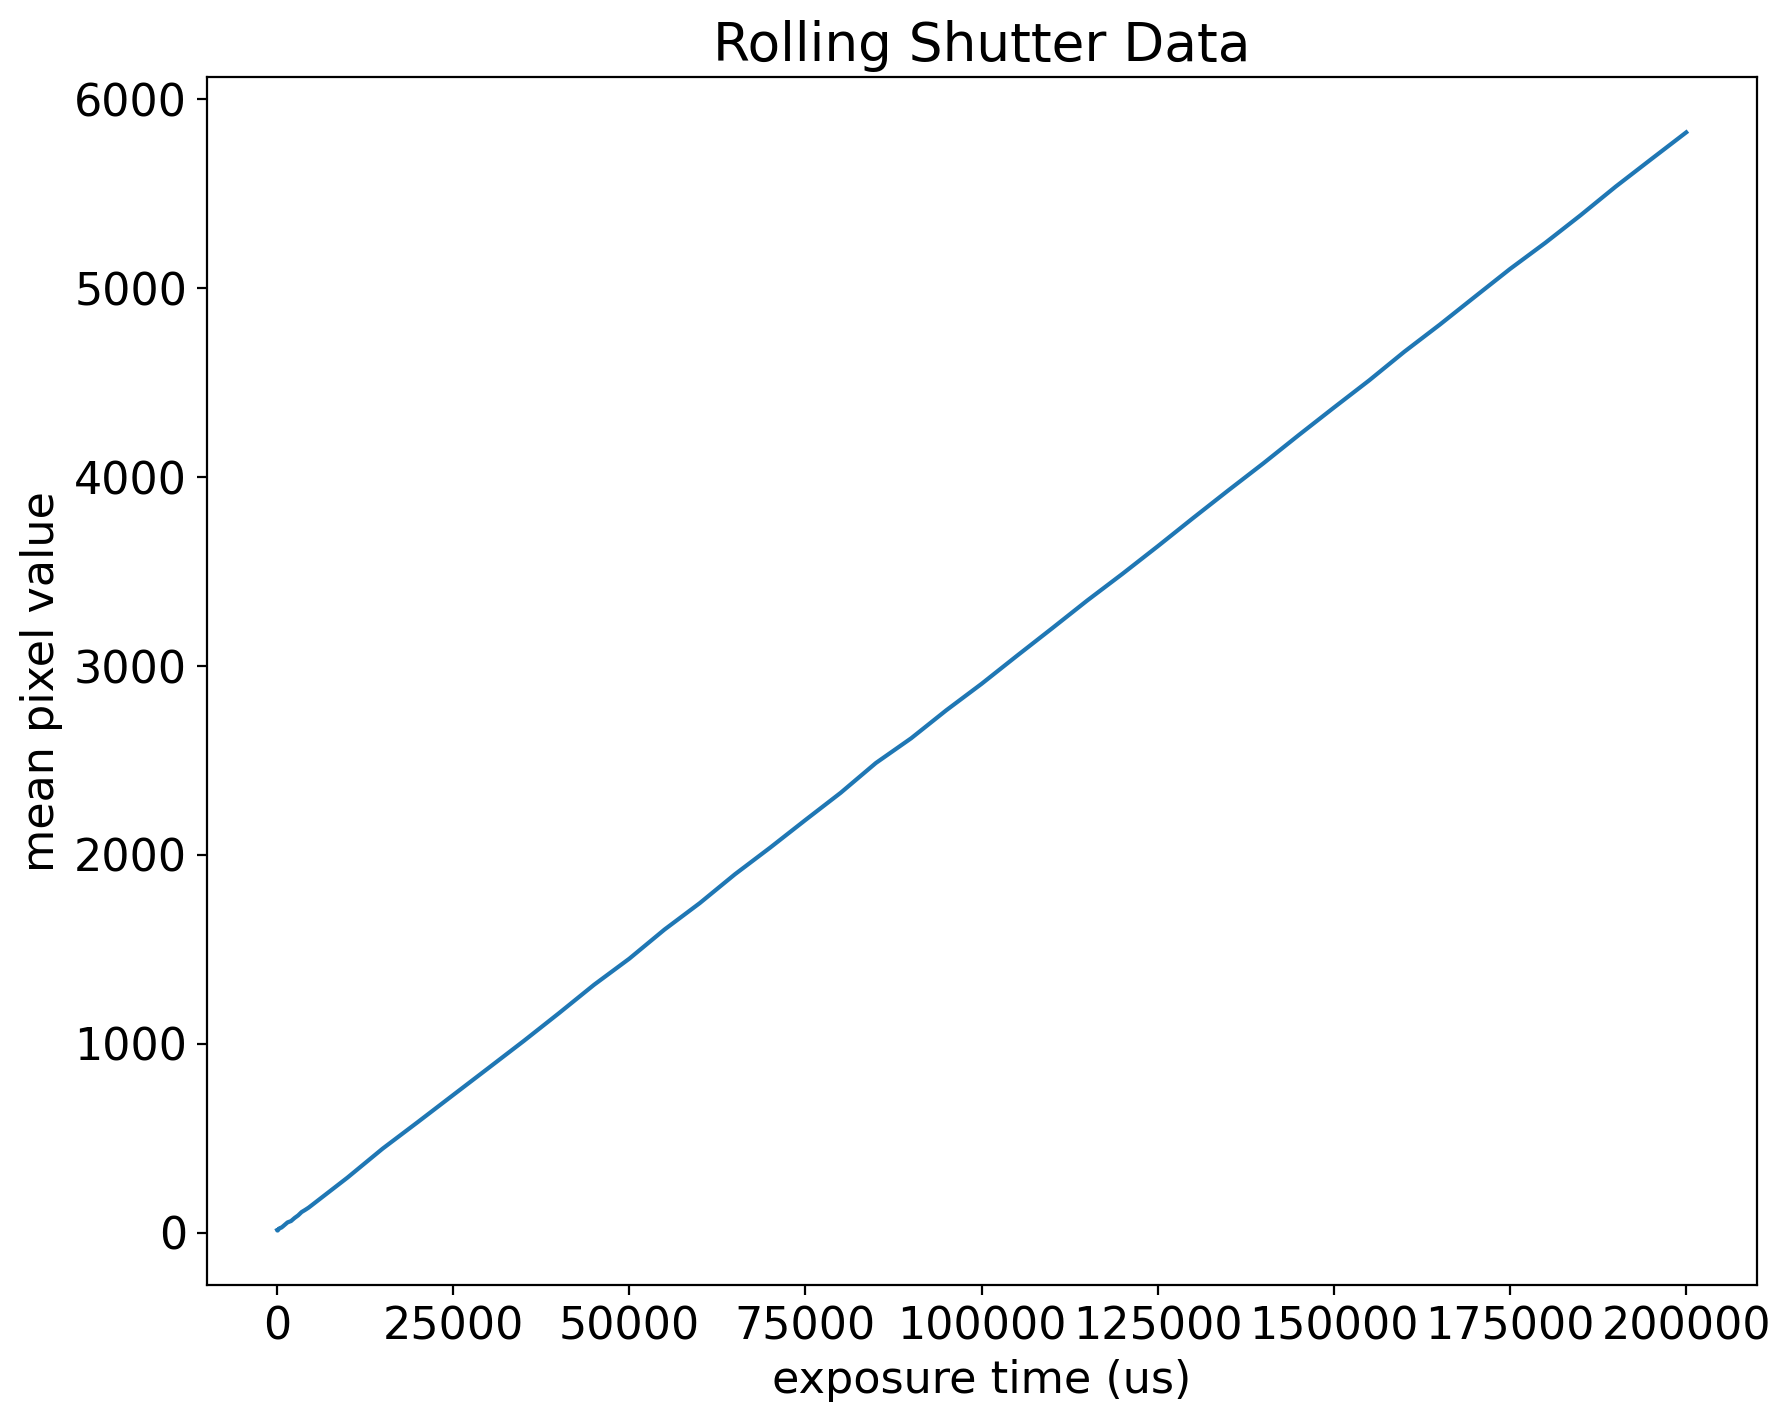

In [22]:
plt.plot(t_exp_array, mean_image_pixel_vals)
plt.xlabel("exposure time (us)")
plt.ylabel("mean pixel value")
plt.title("Rolling Shutter Data")
plt.show()

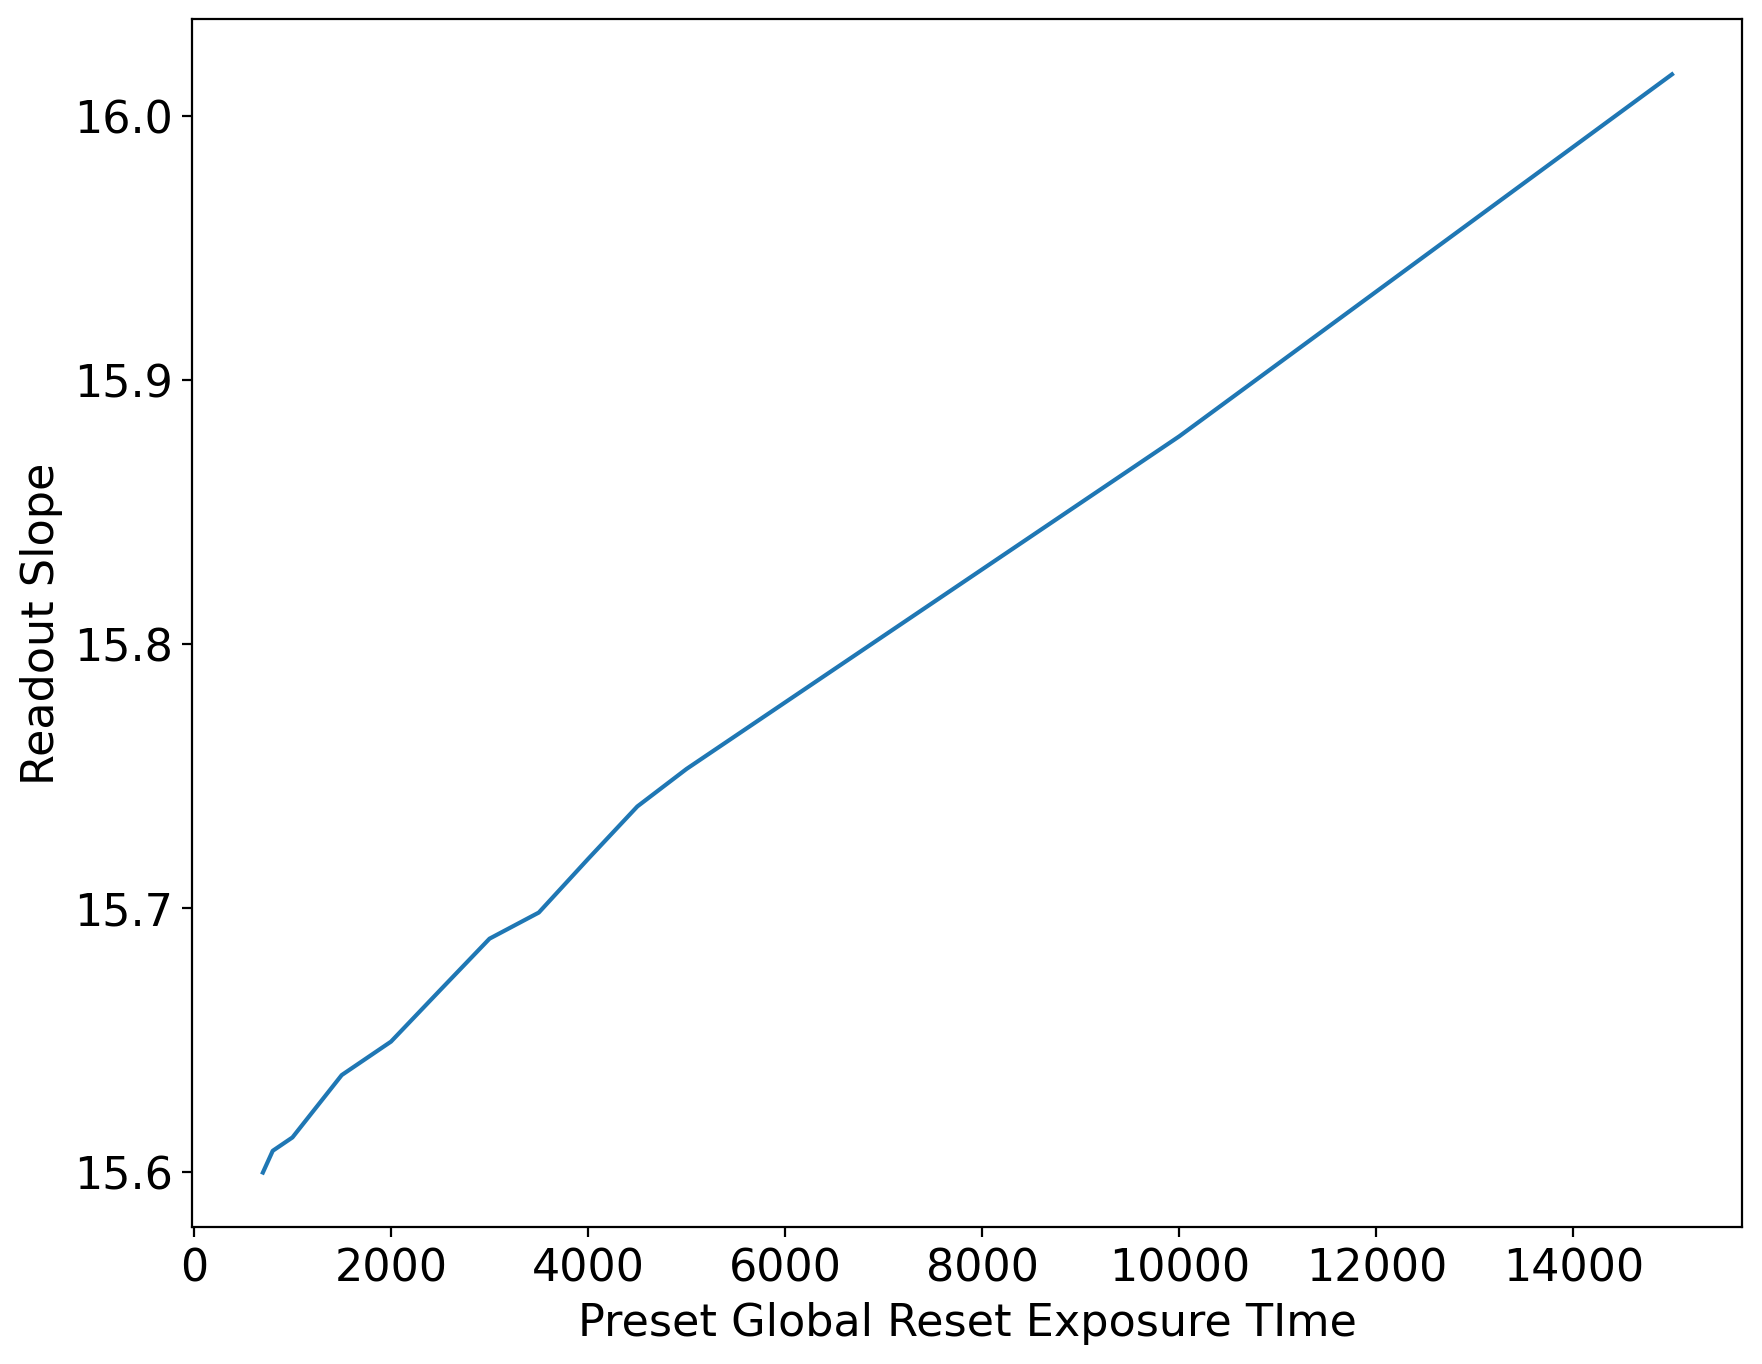

In [24]:
slopes = []
for exp_time in gr_data.keys():
    slope = np.polyfit(range(len(gr_data[exp_time])), gr_data[exp_time], 1)[0]
    slopes.append(slope)
plt.plot(gr_data.keys(), slopes)
plt.xlabel("Preset Global Reset Exposure TIme")
plt.ylabel("Readout Slope")
plt.show()

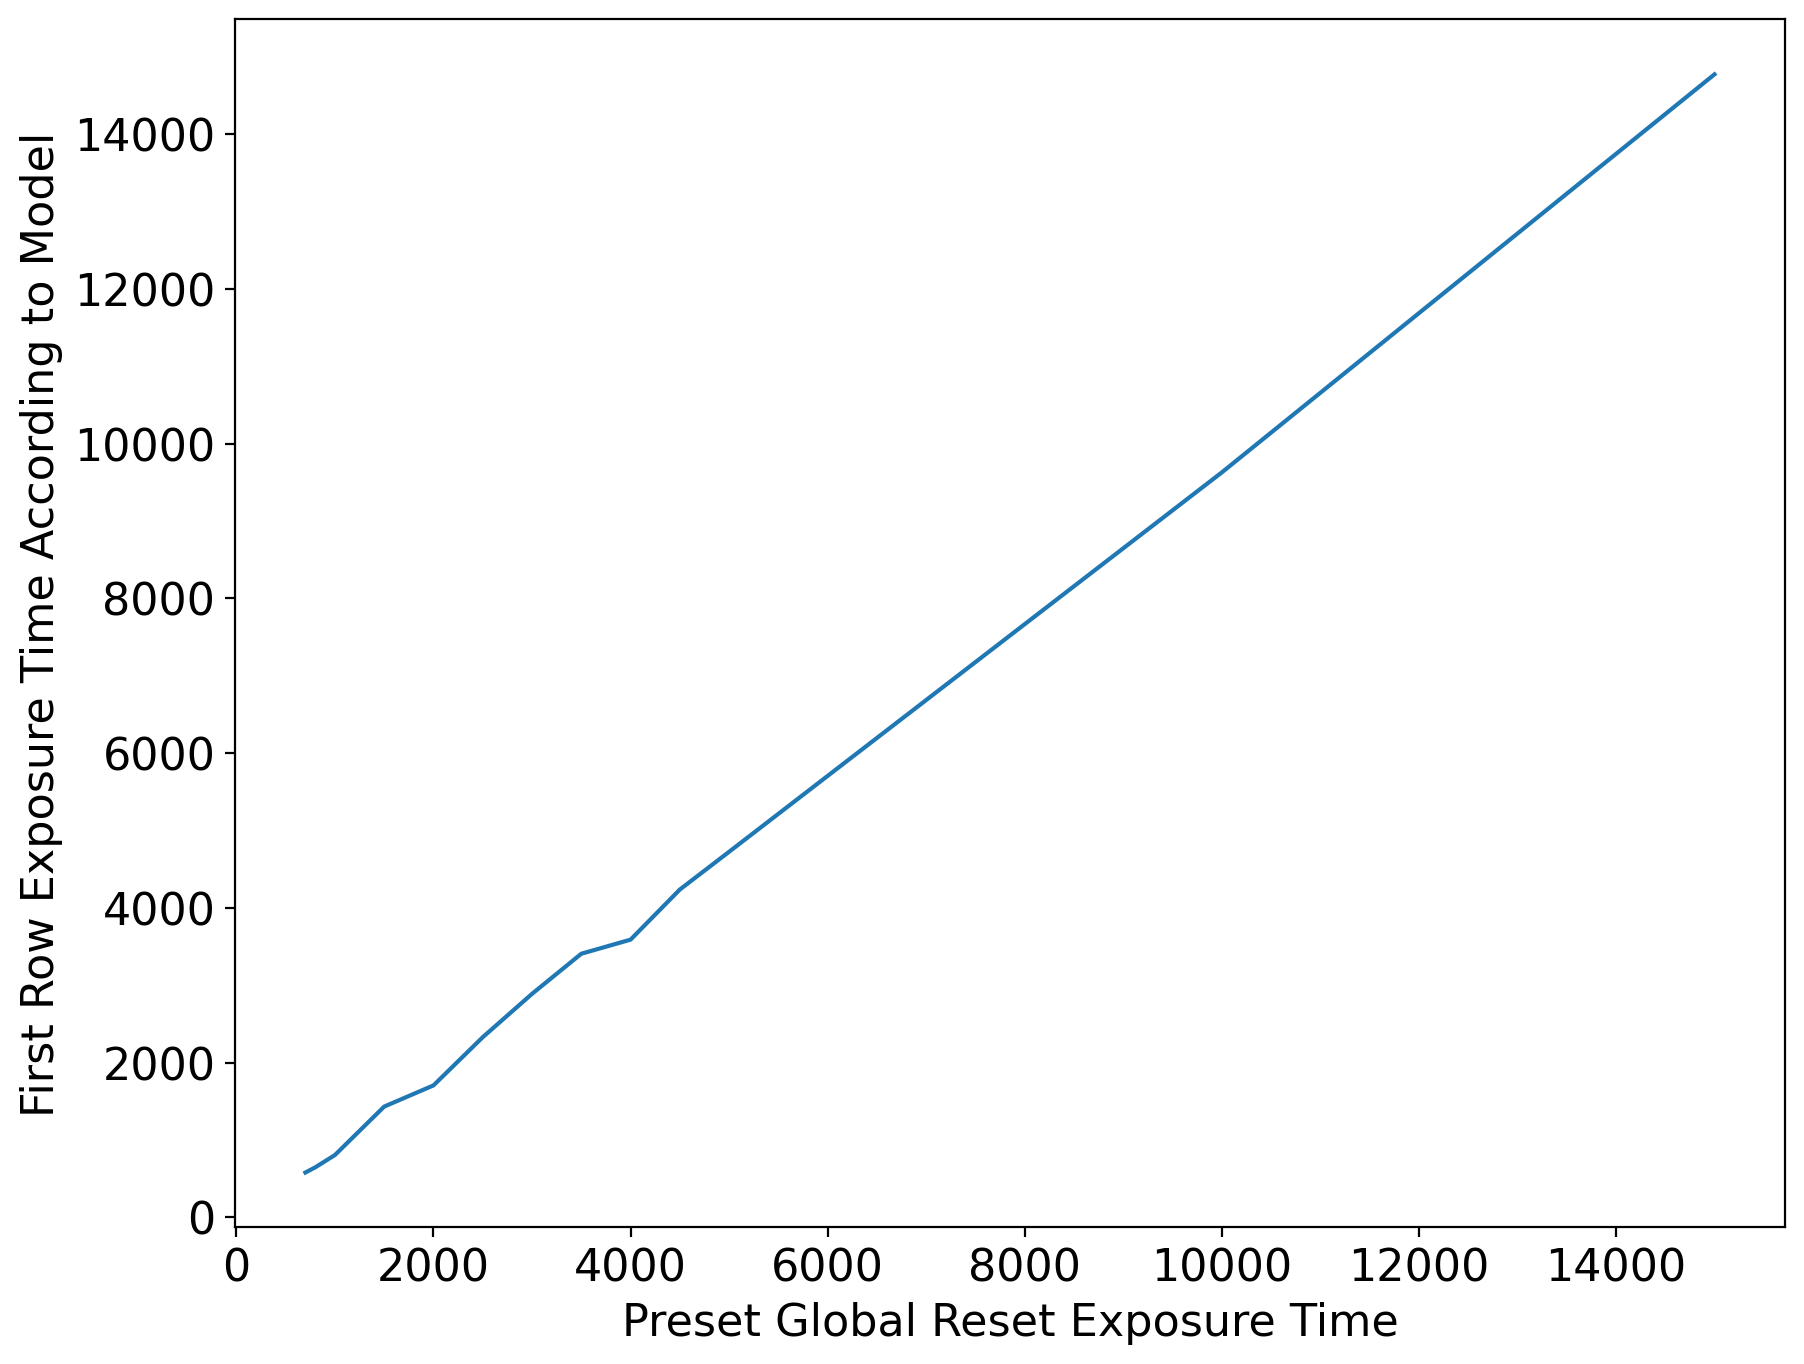

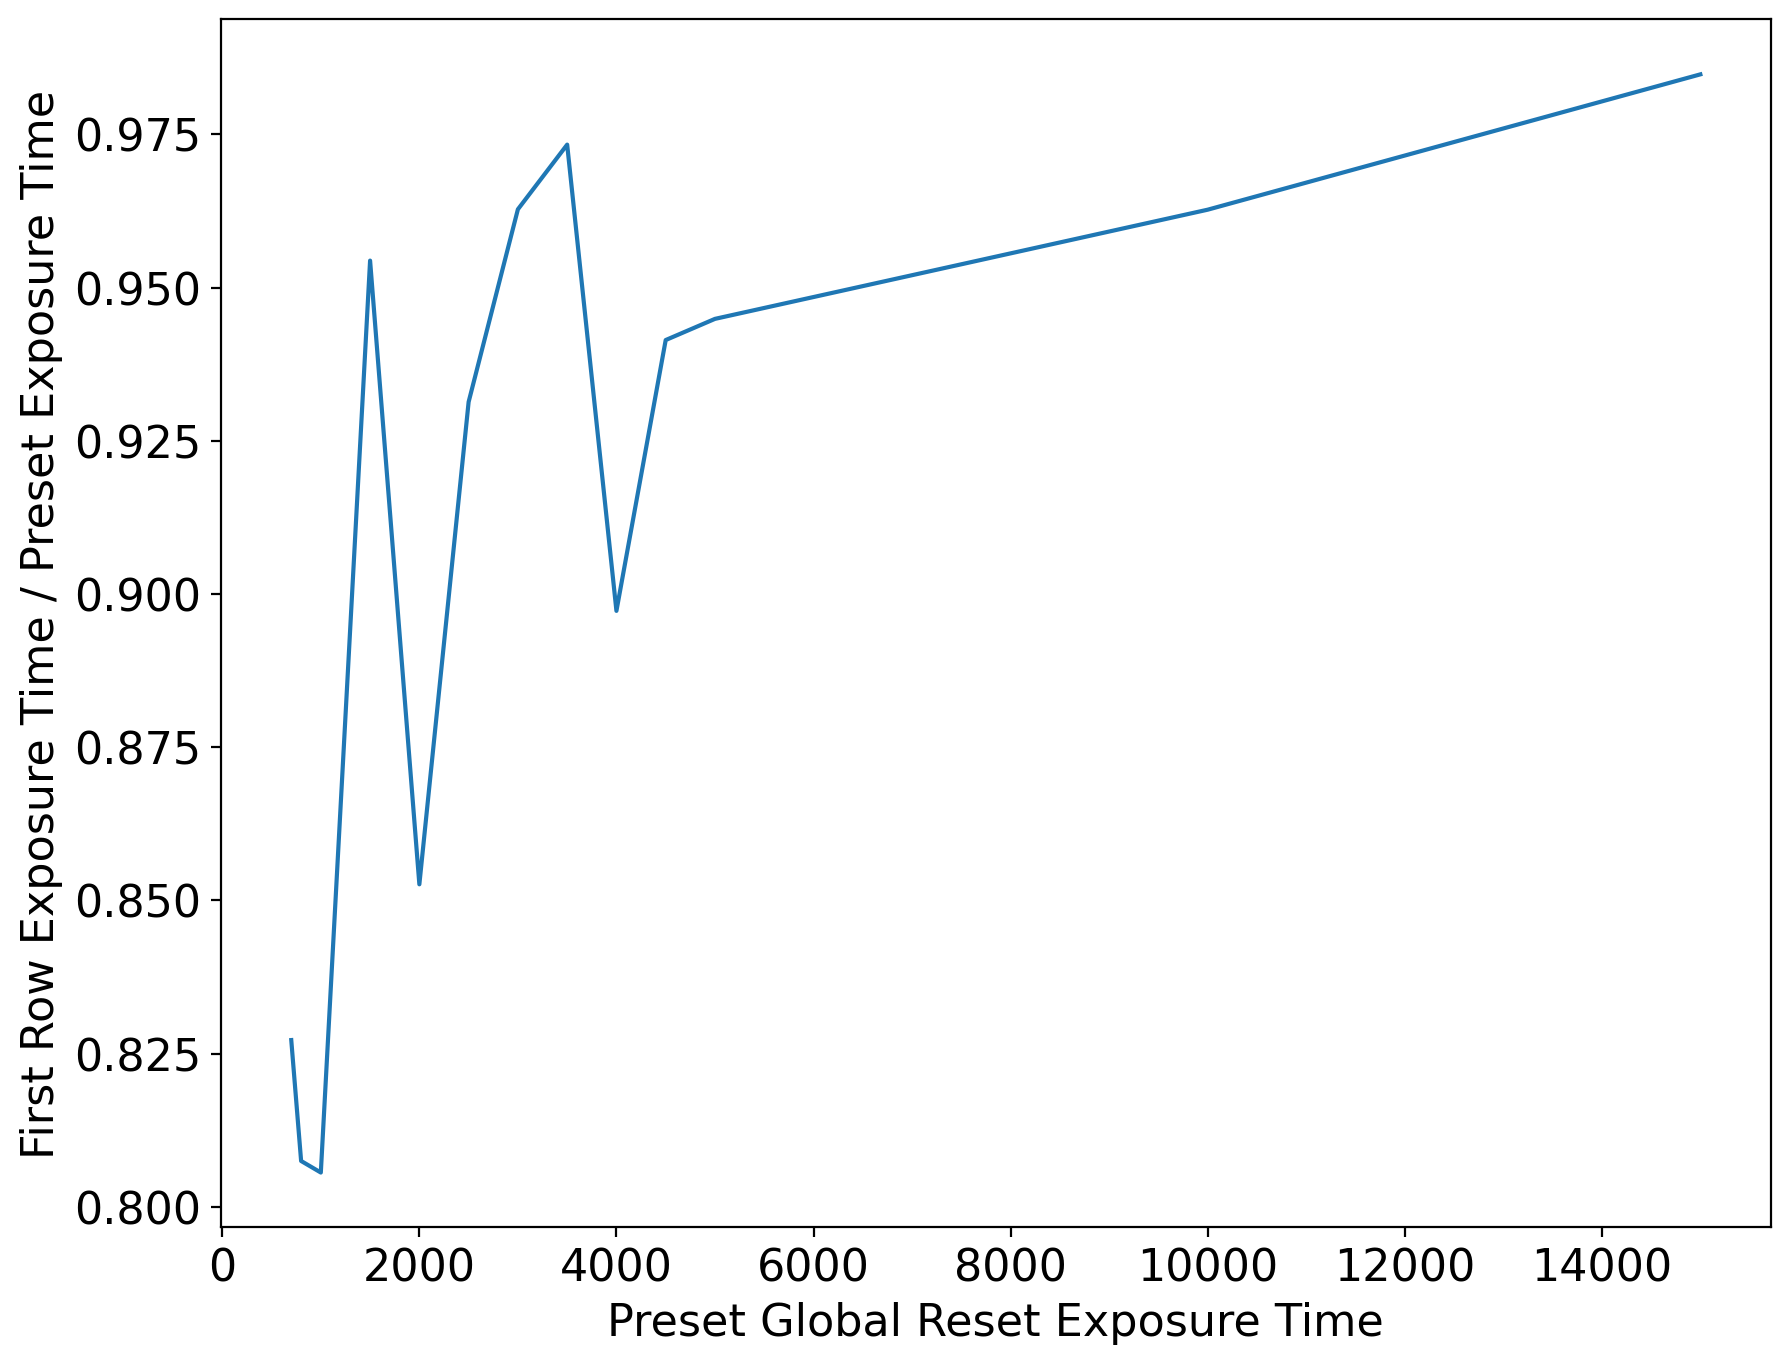

In [32]:
y_intercepts = []
for exp_time in gr_data.keys():
    y_intercept = gr_data[exp_time][0]
    y_intercepts.append(y_intercept)
plt.plot(gr_data.keys(), y_intercepts)
plt.xlabel("Preset Global Reset Exposure Time")
plt.ylabel("First Row Exposure Time According to Model")
plt.show()


y_intercepts_divided = []
for exp_time in gr_data.keys():
    y_intercept = gr_data[exp_time][0]
    y_intercepts_divided.append(y_intercept / exp_time)
plt.plot(gr_data.keys(), y_intercepts_divided)
plt.xlabel("Preset Global Reset Exposure Time")
plt.ylabel("First Row Exposure Time / Preset Exposure Time")
plt.show()

In [26]:
print(gr_data)

{700: [579.0371366777812, 592.3114724897121, 592.8643832731115, 630.7242216520688, 631.2816094458591, 652.2496876162417, 651.9855440031184, 723.3871442380652, 712.7900606404777, 677.0545636924678, 666.083649727161, 694.6536915429604, 683.8081338686237, 722.8767650533912, 729.3035134709384, 741.6645391629264, 749.4813993071539, 778.4185559750921, 787.2449819626873, 789.9759583017349, 794.3477589494113, 808.5309278708949, 812.2020763922388, 876.0084284973598, 881.8307805119974, 890.3236692254014, 911.4372502335214, 988.4910760882169, 1022.4133838275166, 1052.0847701997156, 1073.5654660599737, 1041.3891923735107, 1037.7762449872616, 1084.3796846615671, 1065.4128301363535, 1058.1578347963105, 1038.116497777044, 1034.7408319415645, 1035.3944754587828, 1106.261072951894, 1125.4226774291533, 1128.4155588761278, 1146.67056874903, 1207.2019877524797, 1215.925442501069, 1228.794608872532, 1223.1401447475887, 1232.0091023339023, 1214.9449772252415, 1260.4739344054979, 1259.6412104726057, 1302.349

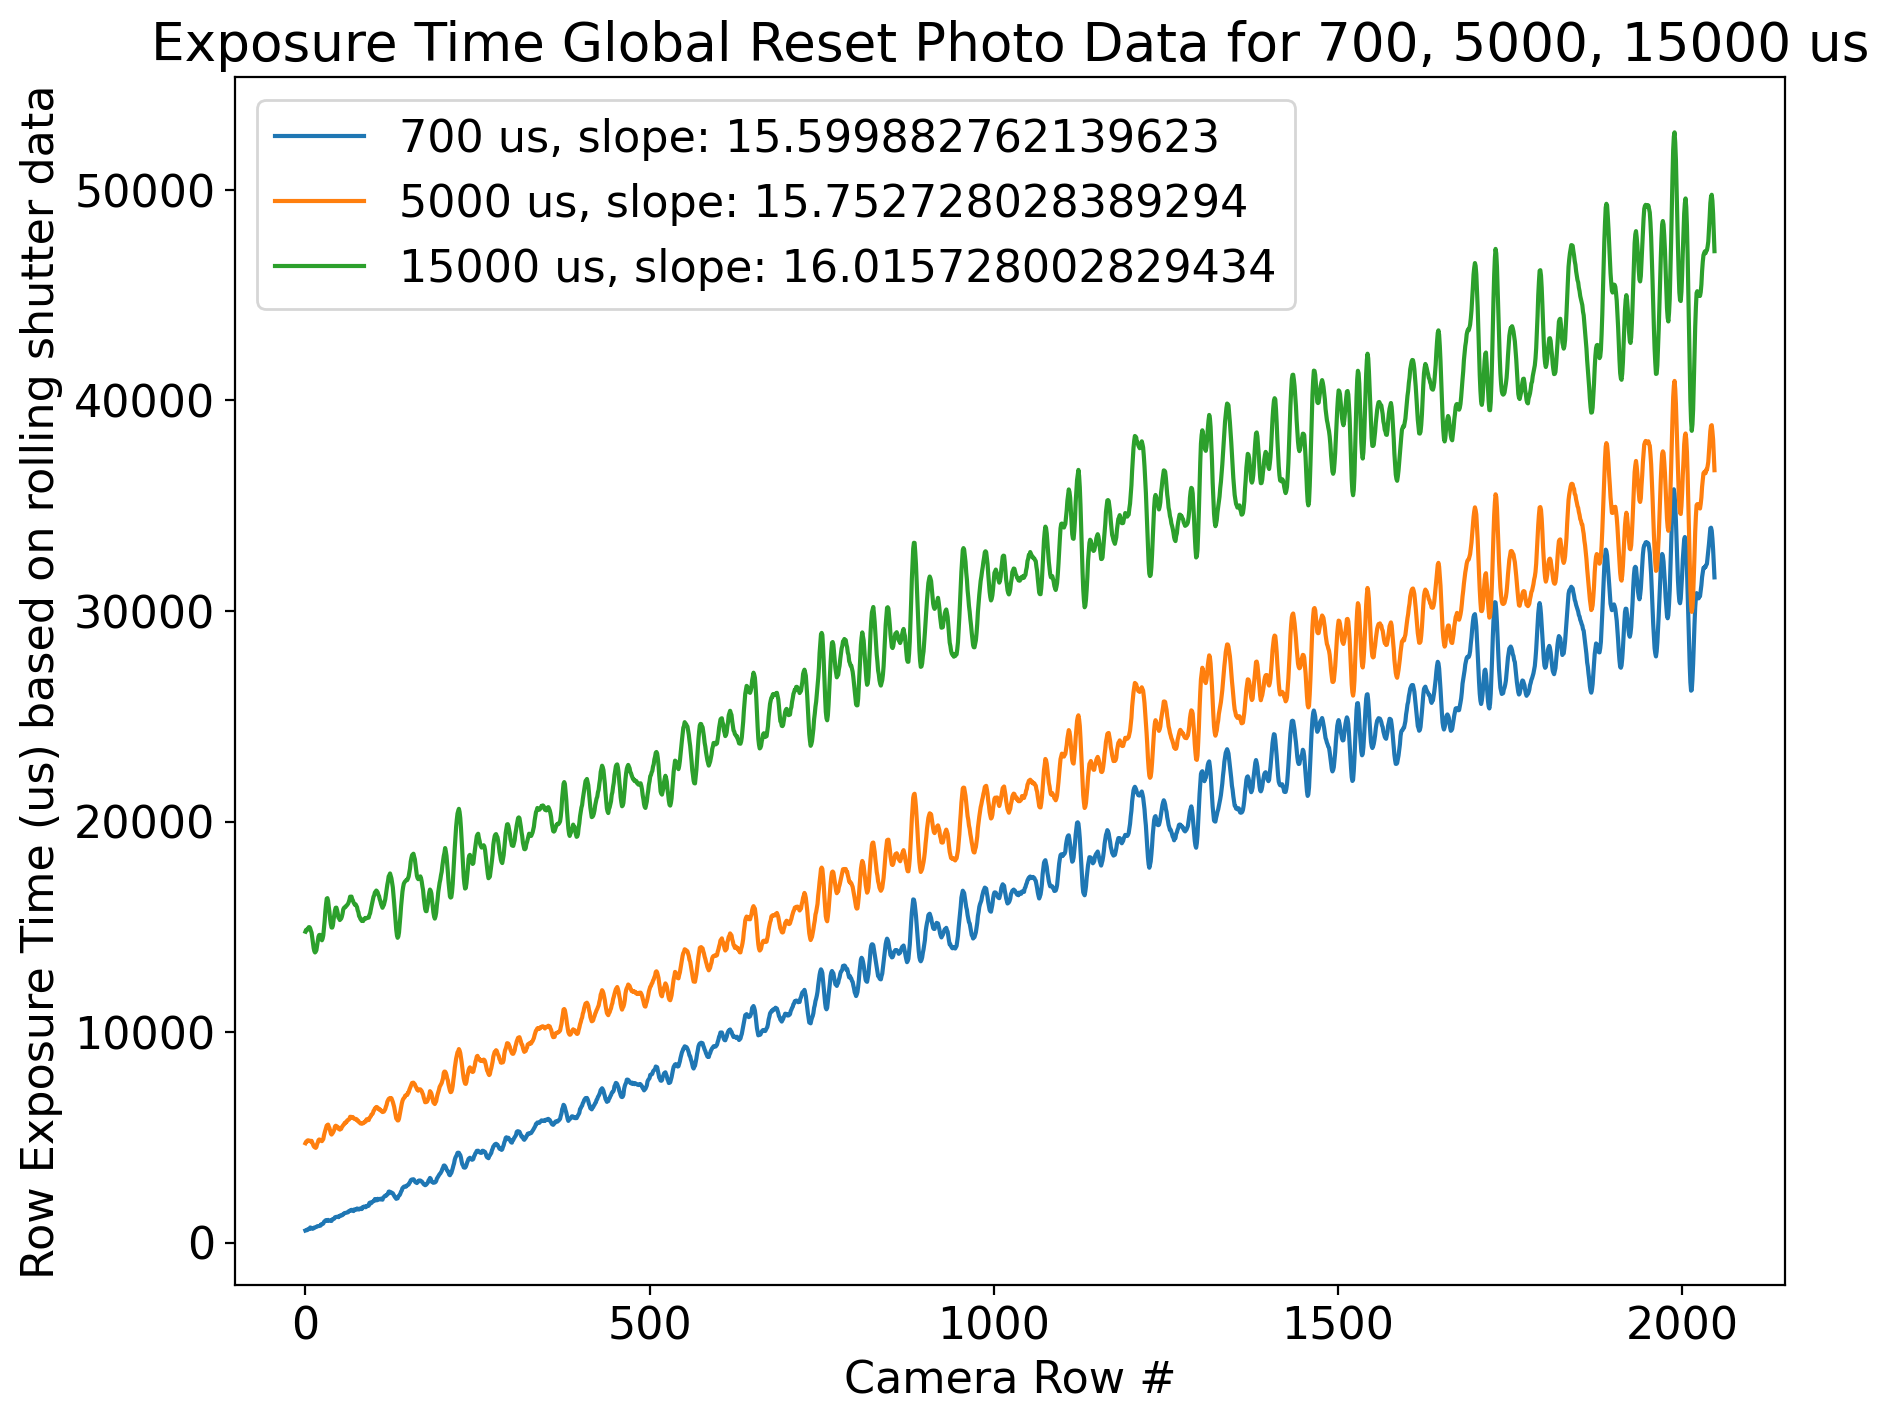

In [33]:
slope1 = np.polyfit(range(len(gr_data[700])), gr_data[700], 1)[0]
slope2 = np.polyfit(range(len(gr_data[5000])), gr_data[5000], 1)[0]
slope3 = np.polyfit(range(len(gr_data[15000])), gr_data[15000], 1)[0]
plt.plot(range(len(gr_data[700])), gr_data[700], label="700 us, slope: {0}".format(slope1))
plt.plot(range(len(gr_data[5000])), gr_data[5000], label="5000 us, slope: {0}".format(slope2))
plt.plot(range(len(gr_data[15000])), gr_data[15000], label="15000 us, slope: {0}".format(slope3))
plt.ylabel("Row Exposure Time (us) based on rolling shutter data")
plt.xlabel("Camera Row #")
plt.title("Exposure Time Global Reset Photo Data for 700, 5000, 15000 us")
plt.legend()
plt.show() 

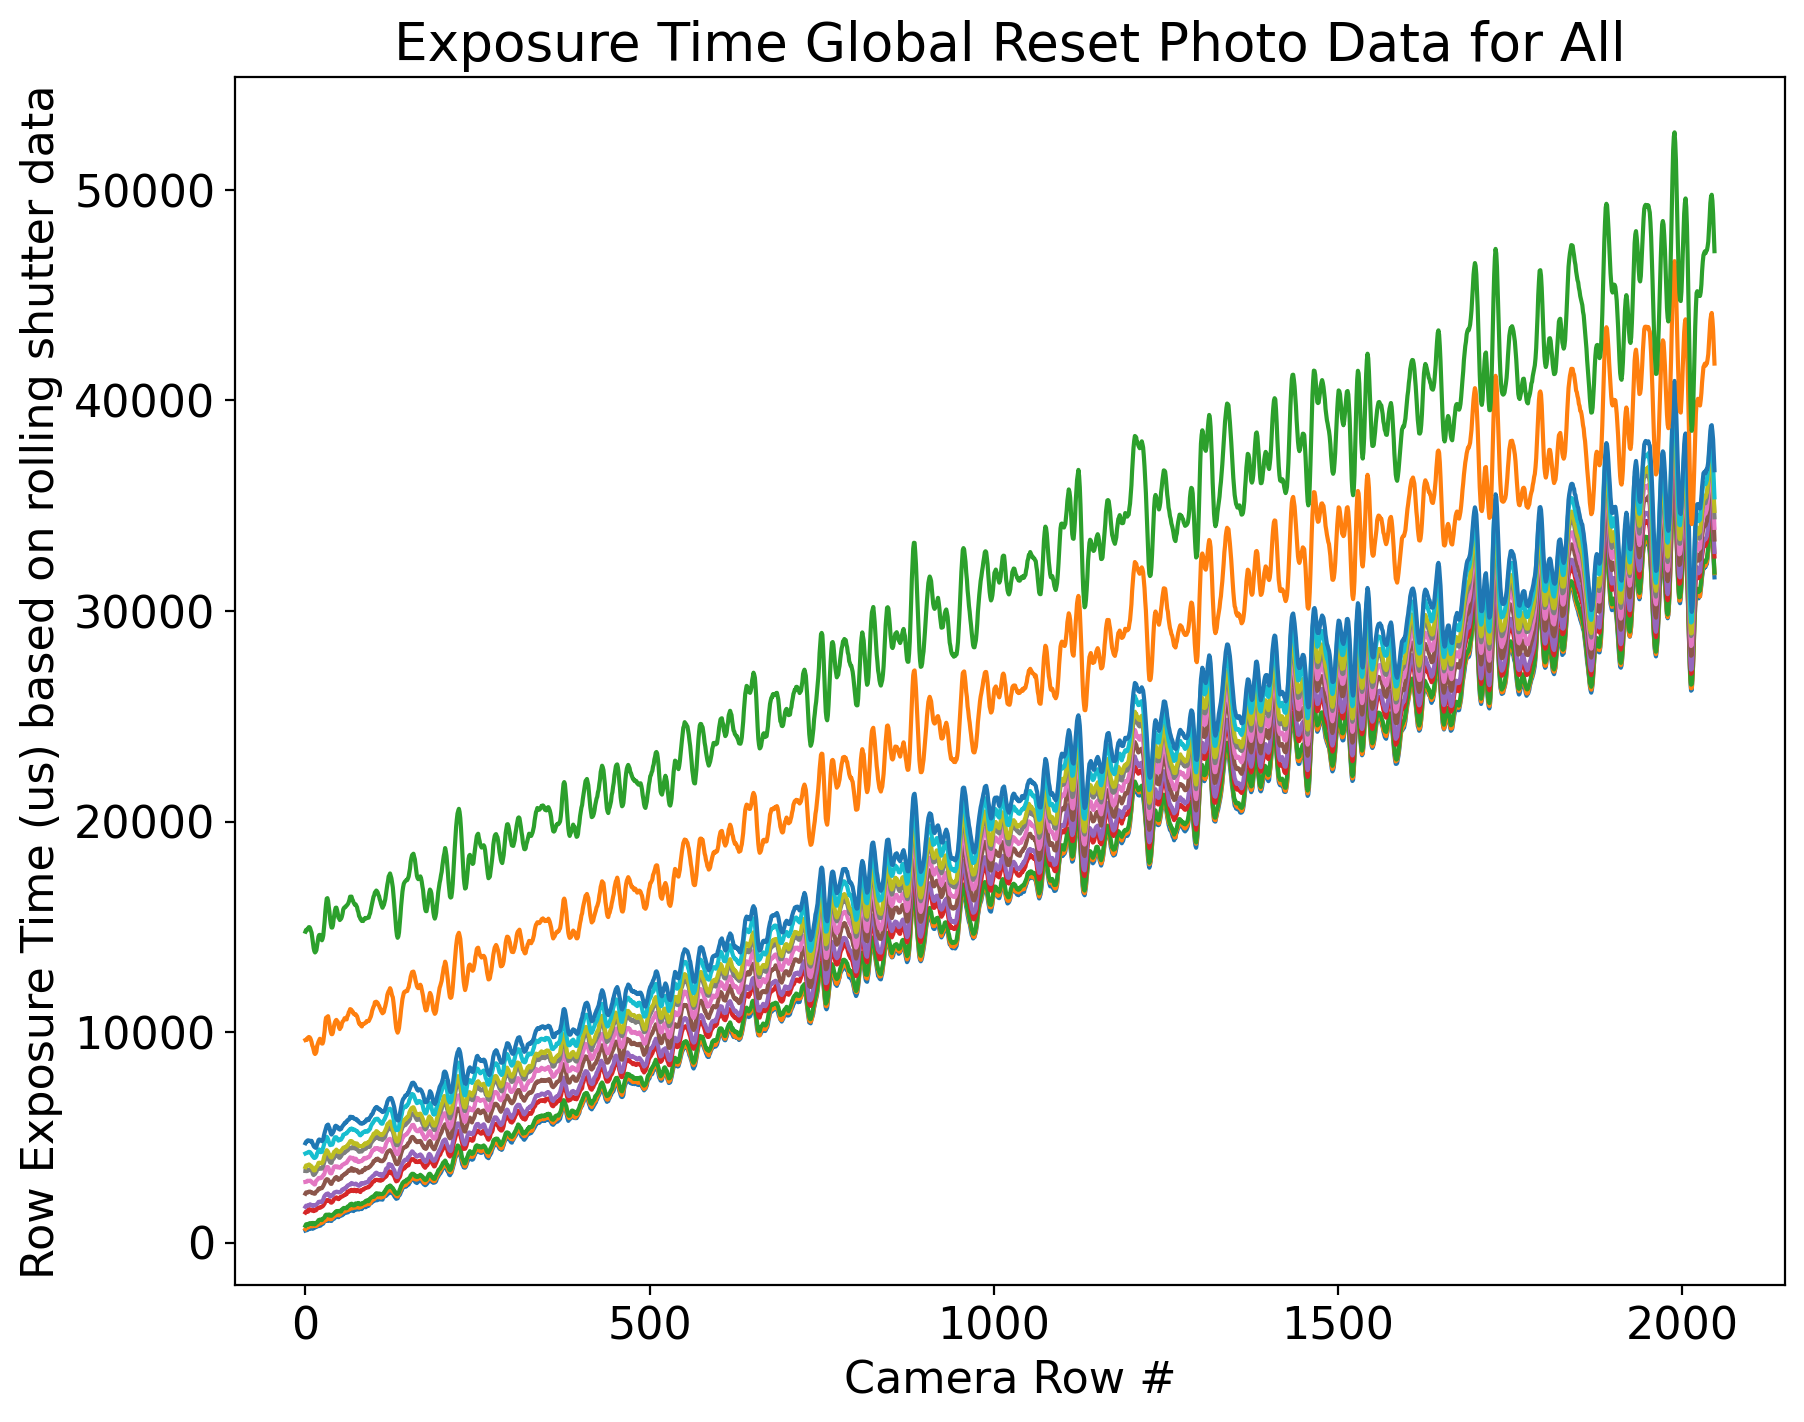

In [37]:
for exp_time in gr_data.keys():
    plt.plot(range(len(gr_data[exp_time])), gr_data[exp_time])
plt.ylabel("Row Exposure Time (us) based on rolling shutter data")
plt.xlabel("Camera Row #")
plt.title("Exposure Time Global Reset Photo Data for All")
plt.show() 